In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
from load_data_and_distribution_analisys import load_dataset_cleaned, plot_confusion_matrix, split_dataset_v1

/Users/marcodeano/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/marcodeano/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Test per la verifica della separabilità tra "Ex-fumatori" e "Fumatori"

In questo notebook viene riportata la seconda parte del test iniziato nel notebook `separation_smokers_non_smokers.ipynb` e nel quale l'obiettivo è quello di valutare se esistono pattern che consentano di distinguere in modo più o meno marcato la classe degli "Ex-fumatori" dai "Fumatori". I modelli utilizzati sono i medesimi del notebook citato.

In [2]:
dataset = load_dataset_cleaned()

Path to dataset files: /Users/marcodeano/.cache/kagglehub/datasets/sooyoungher/smoking-drinking-dataset/versions/2
   sex  age  height  weight  waistline  sight_left  sight_right  hear_left  \
0    1   35     170      75       90.0         1.0          1.0        1.0   
1    1   30     180      80       89.0         0.9          1.2        1.0   
2    1   40     165      75       91.0         1.2          1.5        1.0   
3    1   50     175      80       91.0         1.5          1.2        1.0   
4    1   50     165      60       80.0         1.0          1.2        1.0   

   hear_right    SBP  ...  LDL_chole  triglyceride  hemoglobin  urine_protein  \
0         1.0  120.0  ...      126.0          92.0        17.1            1.0   
1         1.0  130.0  ...      148.0         121.0        15.8            1.0   
2         1.0  120.0  ...       74.0         104.0        15.8            1.0   
3         1.0  145.0  ...      104.0         106.0        17.6            1.0   
4         1

# Predizioni

In [3]:
X_smoke, y_smoke, X_drink, y_drink = split_dataset_v1(dataset)

In [4]:
pipelines = {
    "random_forest": Pipeline([("random_forest", RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_split=50, random_state=42, class_weight='balanced', n_jobs=-1))]),
    "adaboost": Pipeline([("scaler", StandardScaler()), ("adaboost", AdaBoostClassifier(n_estimators=100, random_state=42))]),
    "svm": Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC(random_state=42, class_weight='balanced'))]),
    "knn": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=500, n_jobs=-1))]),
}

In [5]:
idx = np.where(y_smoke == 2)[0]
X_ex_smoke = X_smoke.iloc[idx]
y_ex_smoke = y_smoke.iloc[idx]
print(X_ex_smoke.shape, y_ex_smoke.shape)

idx = np.where(y_smoke == 3)[0]
X_actual_smoke = X_smoke.iloc[idx]
y_actual_smoke = y_smoke.iloc[idx]
print(X_actual_smoke.shape, y_actual_smoke.shape)

X_smoke = pd.concat([X_ex_smoke, X_actual_smoke])
y_smoke = np.concatenate((y_ex_smoke, y_actual_smoke))
print(X_smoke.shape, y_smoke.shape)

(157925, 22) (157925,)
(195245, 22) (195245,)
(353170, 22) (353170,)


In [ ]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_smoke, y_smoke, test_size=0.2, random_state=42, stratify=y_smoke)

In [ ]:
model = {
    "svc": Pipeline([("scaler", StandardScaler()), ("svc", LinearSVC(random_state=42, class_weight='balanced'))]),
    "knn": Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=130, n_jobs=-1))]),
    "rf": Pipeline([("random_forest", RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=50, random_state=42, class_weight='balanced', n_jobs=-1))]),
    "adaboost": Pipeline([("scaler", StandardScaler()), ("adaboost", AdaBoostClassifier(n_estimators=100, random_state=42))])
}

In [ ]:
model["svc"].fit(X_train_s, y_train_s)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', LinearSVC(class_weight='balanced', random_state=42))])

              precision    recall  f1-score   support

           0       0.60      0.63      0.61     31616
           1       0.69      0.66      0.67     39086

    accuracy                           0.64     70702
   macro avg       0.64      0.64      0.64     70702
weighted avg       0.65      0.64      0.65     70702



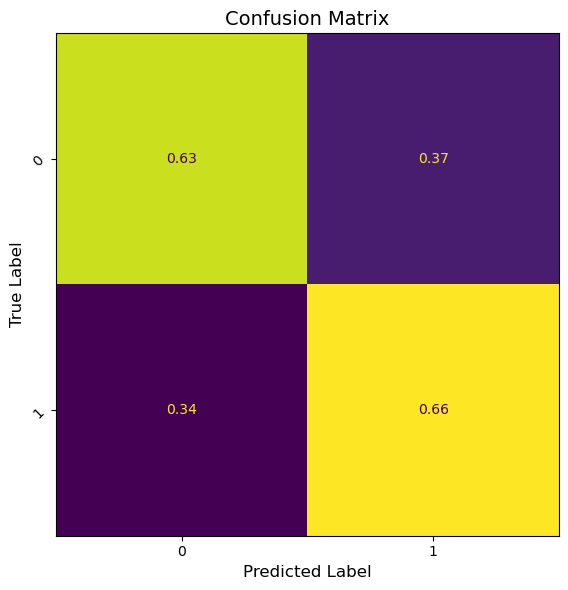

In [ ]:
y_pred_smoke = model["svc"].predict(X_test_s)

report = classification_report(y_test_s, y_pred_smoke)
print(report)
plot_confusion_matrix(y_test_s, y_pred_smoke, model["svc"].classes_, "Confusion Matrix")

In [ ]:
model["rf"].fit(X_train_s, y_train_s)

Pipeline(steps=[('random_forest',
                 RandomForestClassifier(class_weight='balanced', max_depth=50,
                                        min_samples_split=50, n_jobs=-1,
                                        random_state=42))])

              precision    recall  f1-score   support

           0       0.62      0.59      0.60     31616
           1       0.68      0.71      0.70     39086

    accuracy                           0.66     70702
   macro avg       0.65      0.65      0.65     70702
weighted avg       0.65      0.66      0.65     70702



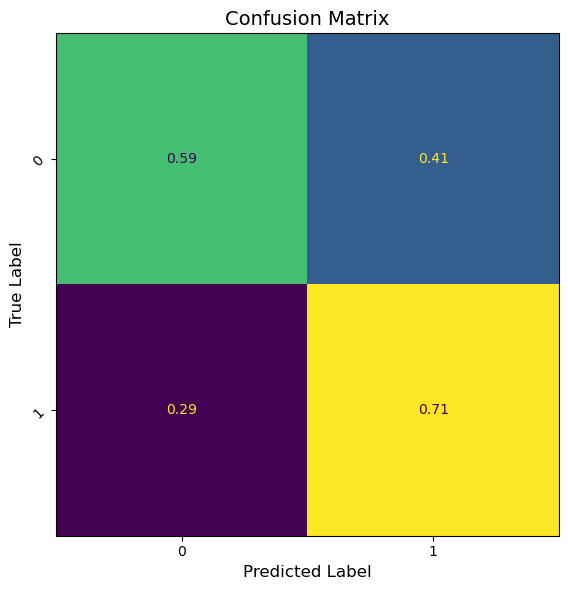

In [ ]:
y_pred_smoke = model["rf"].predict(X_test_s)

report = classification_report(y_test_s, y_pred_smoke)
print(report)
plot_confusion_matrix(y_test_s, y_pred_smoke, model["rf"].classes_, "Confusion Matrix")

In [ ]:
model["knn"].fit(X_train_s, y_train_s)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_jobs=-1, n_neighbors=130))])

              precision    recall  f1-score   support

           0       0.63      0.51      0.56     31616
           1       0.66      0.75      0.70     39086

    accuracy                           0.64     70702
   macro avg       0.64      0.63      0.63     70702
weighted avg       0.64      0.64      0.64     70702



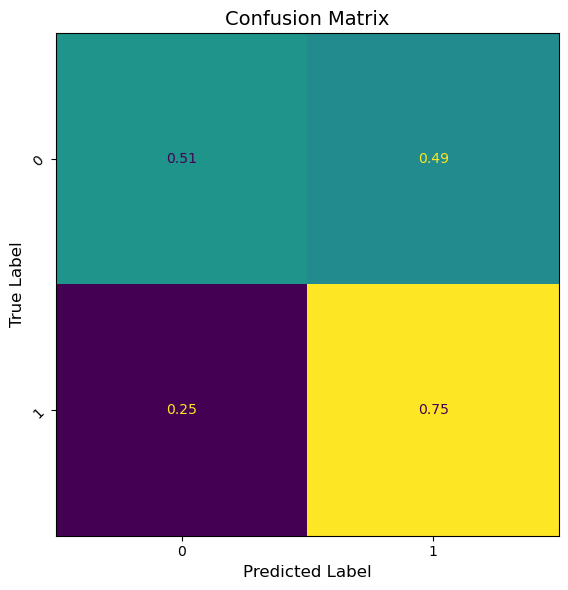

In [ ]:
y_pred_smoke = model["knn"].predict(X_test_s)

report = classification_report(y_test_s, y_pred_smoke)
print(report)
plot_confusion_matrix(y_test_s, y_pred_smoke, model["knn"].classes_, "Confusion Matrix")

In [ ]:
model["adaboost"].fit(X_train_s, y_train_s)

Pipeline(steps=[('scaler', StandardScaler()),
                ('adaboost',
                 AdaBoostClassifier(n_estimators=100, random_state=42))])

              precision    recall  f1-score   support

           0       0.63      0.52      0.57     31616
           1       0.66      0.75      0.70     39086

    accuracy                           0.65     70702
   macro avg       0.65      0.64      0.64     70702
weighted avg       0.65      0.65      0.65     70702



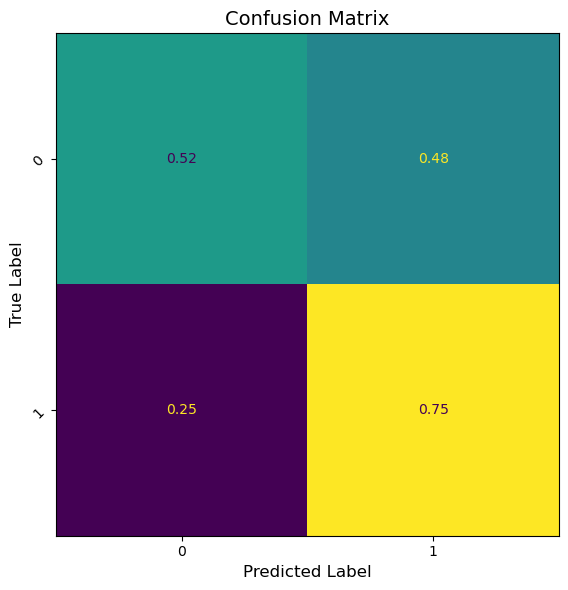

In [ ]:
y_pred_smoke = model["adaboost"].predict(X_test_s)

report = classification_report(y_test_s, y_pred_smoke)
print(report)
plot_confusion_matrix(y_test_s, y_pred_smoke, model["adaboost"].classes_, "Confusion Matrix")

In [ ]:
estimators = [
    ('rf', model["rf"]),
    ('knn', model["knn"]),
    ('adaboost', model["adaboost"])
]

stacking = StackingClassifier(estimators=estimators, final_estimator=LinearSVC(), n_jobs=-1, cv=2)

In [ ]:
stacking.fit(X_train_s, y_train_s)

StackingClassifier(cv=2,
                   estimators=[('svc',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                                 LinearSVC(class_weight='balanced',
                                                           random_state=42))])),
                               ('rf',
                                Pipeline(steps=[('random_forest',
                                                 RandomForestClassifier(class_weight='balanced',
                                                                        max_depth=50,
                                                                        min_samples_split=50,
                                                                        n_jobs=-1,
                                                                        random_state=42))])),
                               ('knn',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('knn',
                                                 KNeighborsClassifier(n_jobs=-1,
                                                                      n_neighbors=130))])),
                               ('adaboost',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('adaboost',
                                                 AdaBoostClassifier(n_estimators=100,
                                                                    random_state=42))])),
                               ('logistic',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('logistic',
                                                 LogisticRegression(n_jobs=-1,
                                                                    random_state=42))]))],
                   final_estimator=RandomForestClassifier(), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.61      0.53      0.57     31616
           1       0.65      0.72      0.69     39086

    accuracy                           0.64     70702
   macro avg       0.63      0.63      0.63     70702
weighted avg       0.63      0.64      0.63     70702



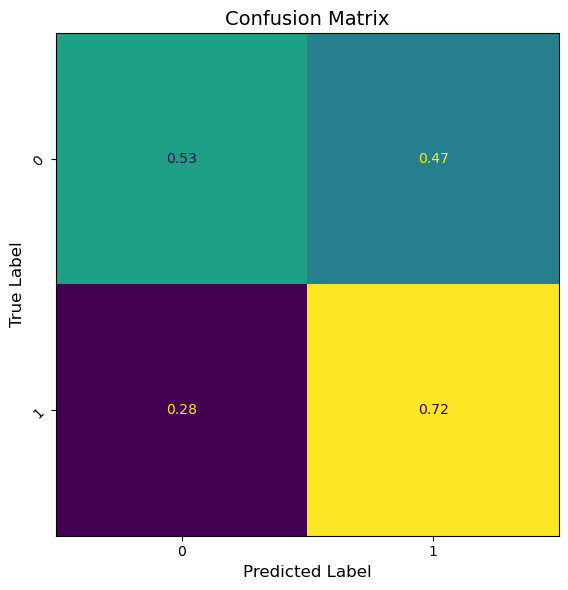

In [ ]:
y_pred_smoke = stacking.predict(X_test_s)

report = classification_report(y_test_s, y_pred_smoke)
print(report)
plot_confusion_matrix(y_test_s, y_pred_smoke, stacking.classes_, "Confusion Matrix")

In [ ]:
estimators = [
    # ("svc", Pipeline([("scaler", StandardScaler()), ("svc", LinearSVC(random_state=42))])),
    ("knn", Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=130, n_jobs=-1))])),
    ("rf", Pipeline([("random_forest", RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=50, random_state=42, class_weight='balanced', n_jobs=-1))])),
    ("adaboost", Pipeline([("scaler", StandardScaler()), ("adaboost", AdaBoostClassifier(n_estimators=100, random_state=42))]))
]

voting = VotingClassifier(estimators=estimators, n_jobs=-1, voting='soft')

In [ ]:
voting.fit(X_train_s, y_train_s)

VotingClassifier(estimators=[('knn',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('knn',
                                               KNeighborsClassifier(n_jobs=-1,
                                                                    n_neighbors=130))])),
                             ('rf',
                              Pipeline(steps=[('random_forest',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=50,
                                                                      min_samples_split=50,
                                                                      n_jobs=-1,
                                                                      random_state=42))])),
                             ('adaboost',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('adaboost',
                                               AdaBoostClassifier(n_estimators=100,
                                                                  random_state=42))])),
                             ('logistic',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('logistic',
                                               LogisticRegression(n_jobs=-1,
                                                                  random_state=42))]))],
                 n_jobs=-1, voting='soft')

              precision    recall  f1-score   support

           0       0.64      0.54      0.58     31616
           1       0.67      0.75      0.71     39086

    accuracy                           0.66     70702
   macro avg       0.65      0.65      0.65     70702
weighted avg       0.65      0.66      0.65     70702



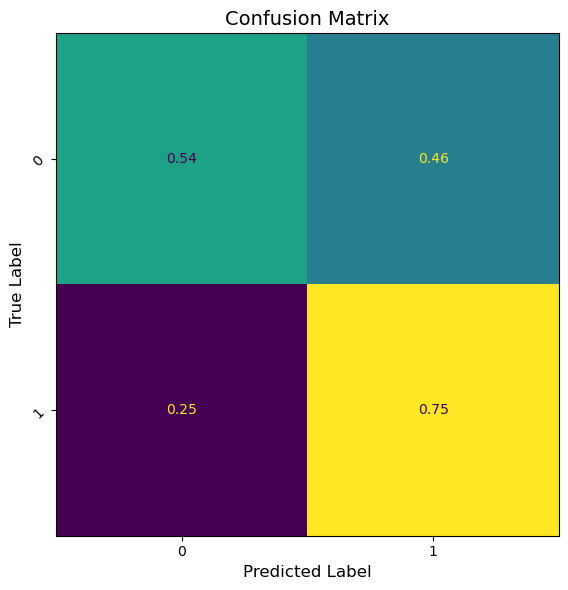

In [ ]:
y_pred_smoke = voting.predict(X_test_s)

report = classification_report(y_test_s, y_pred_smoke)
print(report)
plot_confusion_matrix(y_test_s, y_pred_smoke, voting.classes_, "Confusion Matrix")